In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.multivariate.manova import MANOVA

from vr2f.eyetracking import et_plot_gaze_saccades
from vr2f.eyetracking.et_viz_utils import plot_image, get_saliency_map
from vr2f.utils.stats import run_rmanova_and_posthoc, check_dispersion
from vr2f.staticinfo import PATHS, COLORS, CONSTANTS, TIMINGS

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
paths = PATHS()
colors = COLORS()
constants = CONSTANTS()
cm = constants.CM
timings = TIMINGS()
palette = colors.COLDICT

# 1. Visualize gaze traces and saccades

You can plot the supplementary figures to visualize the gaze and the detected saccades for specific trials like this:

In [4]:
# read in the preprocessed data
pattern = "withoutblinks-preproc.csv"

sub_list_str_et = [f for f in os.listdir(paths.DATA_ET_PREPROC) if pattern in f]
sub_list_str_et = [f.split("-")[0] for f in sub_list_str_et]
sub_list_str_et = np.unique(sorted(sub_list_str_et))

data_preproc = []
for sub_id in sorted(sub_list_str_et):
    fname = Path(paths.DATA_ET_PREPROC, f"{sub_id}-ET-{pattern}")
    df_clean = pd.read_csv(fname, sep=",")
    df_clean["sub_id"] = sub_id
    data_preproc.append(df_clean)

df_all = pd.concat(data_preproc, ignore_index=True)

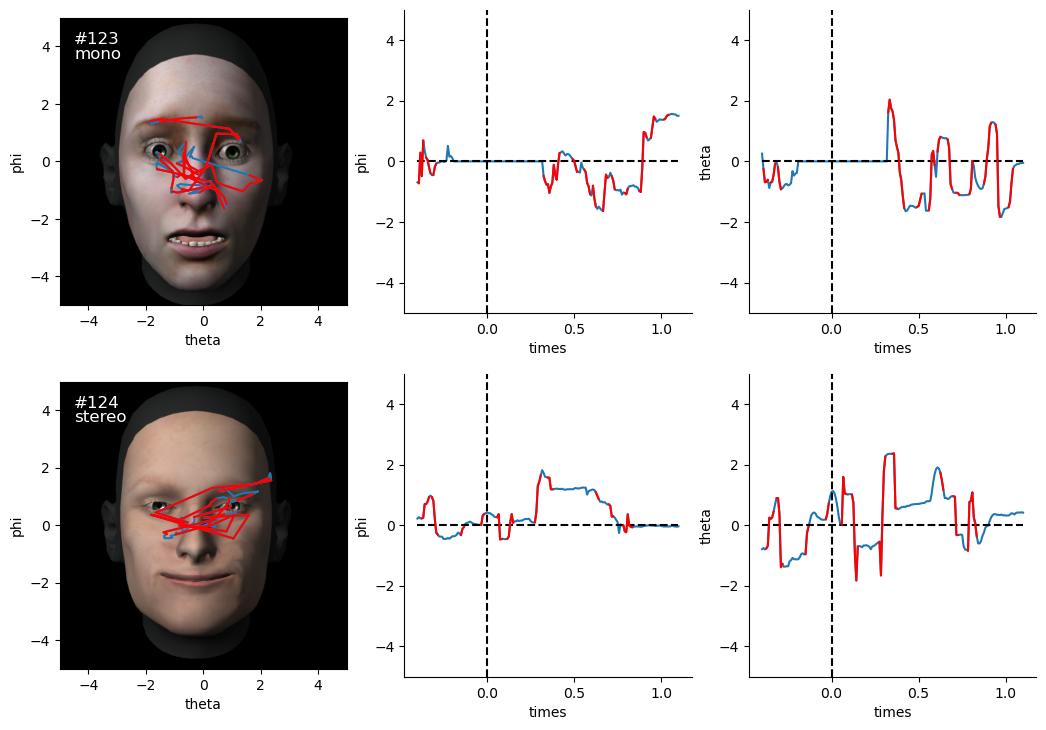

In [5]:
sub_id = "VR2FEM_S05"
trial_range = range(123, 125)

save_fig = False
myfig = et_plot_gaze_saccades.plot_gaze_sacc_per_trial(df_all, sub_id, trial_range, sfreq=120, min_sac_amp=0)

# 2. Load gaze and saccade data

In [6]:
fpath = paths.DATA_ET / "02_gaze"
saccades = pd.read_csv(Path(fpath, "saccades_all.csv"))
df_gaze = pd.read_csv(Path(fpath, "gaze_all.csv"))

# A DF with the design matrix:
design_df = (df_gaze
              .loc[:, ["sub_id", "trial_num", "emotion", "viewcond", "avatar_id"]]
              .drop_duplicates()
)

cond_dict = {
    "viewcond": {1: "mono", 2: "stereo"},
    "emotion": {1: "neutral", 2: "happy", 3: "angry", 4: "surprised"},
    "avatar_id": {1: "Woman_01", 2: "Woman_04", 3: "Woman_08"},
}

# timing parameters:
tw_p1_start, tw_p1_end = timings.ERP_WINDOWS["P1"]
tw_n170_start, tw_n170_end = timings.ERP_WINDOWS["N170"]
tw_epn_start, tw_epn_end = timings.ERP_WINDOWS["EPN"]
tw_lpc_start, tw_lpc_end = timings.ERP_WINDOWS["LPC"]

In [7]:
sacc_minamp = constants.ET_SACC_MINAMP
baseline = (-1 * timings.DUR_BL, 0.0)


saccades_baseline = (saccades
                        .query("times_onset < @baseline[0] & \
                                times_onset < @baseline[1] & \
                                  amp_tot > @sacc_minamp")
                        .merge(design_df, on=["sub_id", "trial_num"])
)

saccades_first = (saccades
                    .query("times_onset > 0 & amp_tot > @sacc_minamp")
                    .groupby(["sub_id", "trial_num"], as_index=False)
                    .first()
                    .merge(design_df, on=["sub_id", "trial_num"])
)

tmp_offsets = saccades_first.loc[:,["times_offset", "trial_num"]]

saccades_later = (saccades
                     .merge(tmp_offsets, on=["trial_num"], suffixes=("", "_first"))
                     .query("times_onset > times_offset_first & amp_tot > @sacc_minamp")
                     .merge(design_df, on=["sub_id", "trial_num"])
)

saccades_p1 = (saccades
                .query("times_offset > @tw_p1_start & times_onset < @tw_p1_end & amp_tot > @sacc_minamp")
                .merge(design_df, on=["sub_id", "trial_num"])
)

saccades_n170 = (saccades
                .query("times_offset > @tw_n170_start & times_onset < @tw_n170_end & amp_tot > @sacc_minamp")
                .merge(design_df, on=["sub_id", "trial_num"])
)

saccades_epn = (saccades
                .query("times_offset > @tw_epn_start & times_onset < @tw_epn_end & amp_tot > @sacc_minamp")
                .merge(design_df, on=["sub_id", "trial_num"])
)

saccades_lpc = (saccades
                .query("times_offset > @tw_lpc_start & times_onset < @tw_lpc_end & amp_tot > @sacc_minamp")
                .merge(design_df, on=["sub_id", "trial_num"])
)

# 3. Saccade rate


In [8]:
def plot_saccrate(saccades, color="black"):
  sacc_bins = np.arange(-0.375, 1.0, 0.05)

  saccades["bin"] = pd.cut(saccades["times_onset"], bins=sacc_bins)
  saccades["bin_center"] = saccades["bin"].apply(lambda x: x.mid.round(4))
  ax = saccades.groupby(["bin_center", "sub_id", "trial_num"], observed=False).size().groupby("bin_center", observed=True).mean().plot(kind="bar", color=color, alpha=0.5)

  dat_emo = saccades.groupby(["bin_center", "sub_id", "trial_num", "emotion"], observed=False).size().groupby(["emotion", "bin_center"], observed=True).mean().reset_index()
  print(dat_emo.loc[dat_emo.emotion == "happy", 0])
  ax.plot(dat_emo.loc[dat_emo.emotion == "happy", 0].reset_index(), color=color, alpha=0.5)

  oldticks = ax.get_xticks()  # Get the current x-ticks
  old_labs = ax.get_xticklabels()  # Get the current x-tick labels

  newticks = oldticks[1::2]
  newlabs = old_labs[1::2]

  ax.set_xticks(newticks)  # Apply the yticks to the plot
  # add vline at zero
  ax.axvline(newticks[[float(nl.get_text()) == 0 for nl in newlabs]], color="black", linestyle="--")
  ax.set_xlabel("Time")
  ax.set_ylabel("Saccade rate")
  # rm splines
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  plt.show()

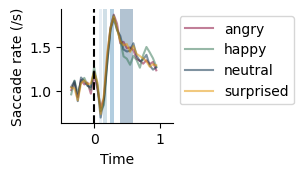

In [10]:
sacc_c = saccades.copy().merge(design_df, on=["sub_id", "trial_num"])
sacc_bins = np.arange(-0.375, 1.0, 0.05)

sacc_c["bin"] = pd.cut(sacc_c["times_onset"], bins=sacc_bins)
sacc_c["bin_center"] = sacc_c["bin"].apply(lambda x: x.mid.round(4))

data_plt = sacc_c.groupby(["bin_center", "sub_id", "trial_num", "emotion"], observed=False).size().groupby(["bin_center", "emotion"], observed=True).mean().to_frame("sacc_rate").reset_index()


fig, ax = plt.subplots(1, 1, 
                       figsize=(2.43 * cm * 1.5 , 2.49 * cm * 1.5 )
                       )
data_plt["sacc_rate"] = data_plt["sacc_rate"] / 0.05  # convert to Hz
sns.lineplot(data=data_plt, x="bin_center", y="sacc_rate", hue="emotion", palette=palette, alpha=0.5, ax=ax)
oldticks = ax.get_xticks()  # Get the current x-ticks
old_labs = ax.get_xticklabels()  # Get the current x-tick labels

newticks = oldticks[1::2]
newlabs = old_labs[1::2]

# ax.set_xticks(newticks)  # Apply the yticks to the plot
# # add vline at zero

# print(np.where([float(nl.get_text()) == 0 for nl in newlabs])[0][0])

# print([float(nl.get_text()) == 0 for nl in newlabs])
# ax.axvline(newticks[np.where([float(nl.get_text()) == 0 for nl in newlabs])[0][0]], color="black", linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Saccade rate (/s)")
# rm splines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axvline(0, color="black", linestyle="--")

ax.set_xlim(-0.5, 1.2)

#remove box around legend
ax.legend(frameon=False)
# rm legend title
ax.get_legend().set_title("")

# hide legend
#ax.get_legend().remove()

# # move legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)


# add a semi-transparent box for the epn window
colors = COLORS()
ax.axvspan(*timings.ERP_WINDOWS["P1"], color=colors.COLDICT["P1"] , alpha=0.3, linewidth=0)
ax.axvspan(*timings.ERP_WINDOWS["N170"], color=colors.COLDICT["N170"] , alpha=0.3, linewidth=0)
ax.axvspan(*timings.ERP_WINDOWS["EPN"], color=colors.COLDICT["EPN"] , alpha=0.3, linewidth=0)
ax.axvspan(*timings.ERP_WINDOWS["LPC"], color=colors.COLDICT["LPC"] , alpha=0.3, linewidth=0)

fig.savefig(
    Path(paths.FIGURES, "saccade-rate_emo-all.pdf"),
    transparent=True,  bbox_inches="tight"
)

# 4. Saccade directions 

/tmp/ipykernel_50294/3043515443.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sacc_plt = (sacc_data_plt
/tmp/ipykernel_50294/3043515443.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sacc_plt = (sacc_data_plt
/tmp/ipykernel_50294/3043515443.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sacc_plt = (sacc_data_plt
/tmp/ipykernel_50294/3043515443.py:26: FutureWarning: The default of observed=False is depr

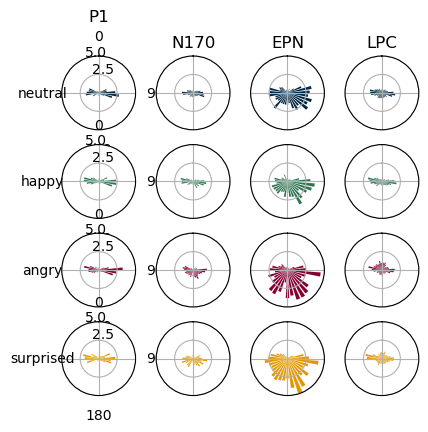

In [11]:
ylims_stage = [#(0, 80),  # baseline
               #(0, 175),  # first sacc
               #(0, 3500),  # later sacc
               (0, 5),
               (0, 5),
               (0, 5),
               (0, 5)
              ]

fig, axs = plt.subplots(len(ylims_stage),4, subplot_kw=dict(polar=True), figsize=(4.67, 4.41))
stage_names = ["P1", "N170", "EPN", "LPC"]

for idx_stage, sacc_data in enumerate([#saccades_baseline,
                                       #saccades_first,
                                       #saccades_later,
                                       saccades_p1,
                                       saccades_n170,
                                       saccades_epn,
                                       saccades_lpc]):
   # bin the saccades in 50 bins
   bins = np.linspace(0, 2*np.pi, 36)
   sacc_data_plt = sacc_data
   sacc_data_plt["angle_bin"] = pd.cut(sacc_data_plt["angle"], bins, right=False)
   sacc_data_plt["bin_center"] = sacc_data_plt["angle_bin"].apply(lambda x: x.mid)

   sacc_plt = (sacc_data_plt
               .groupby(["emotion", "bin_center"], as_index=True)
               .agg({"amp_tot": "count"}).reset_index()
            )

   len_window = timings.ERP_WINDOWS[stage_names[idx_stage]][1] - timings.ERP_WINDOWS[stage_names[idx_stage]][0]
   sacc_plt["amp_tot"] = sacc_plt["amp_tot"] / len_window /200 # arbitrary scaling

   for idx_emo, emo in enumerate(cond_dict["emotion"].values()):
      ax = axs[idx_emo, idx_stage]
      sacc_plt_emo = sacc_plt.query("emotion == @emo")
      bars = ax.bar(sacc_plt_emo["bin_center"], sacc_plt_emo["amp_tot"], bottom=0, width=(2*np.pi / 50), color=palette[emo])
      ax.set_theta_offset(np.pi/2)
      if idx_emo == 0:
         ax.set_title(f"{stage_names[idx_stage]}")
      else:
         ax.set_title("")
      ax.set_ylim(*ylims_stage[idx_emo])
      ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
      if idx_stage > 0:
         ax.set_yticklabels([])
         ax.set_xticklabels(["", "", "", ""])
      else:
         ax.set_xticklabels(["0", emo, "180", "90"])


fig.savefig(
    Path(paths.FIGURES, "saccade-direction_histograms__emo-all.pdf"),
    transparent=True,  bbox_inches="tight"
)

# 5. Saccade stats

In [13]:
def val2_mean(x):
        return np.mean(np.array(x.tolist()), axis=0)



saccades_count_tw = (saccades
                        .query("times_onset > 0 & \
                                amp_tot > @sacc_minamp")
                        .assign(tw=lambda x:
                                    np.where((x["times_offset"] > tw_p1_start) & (x["times_onset"] < tw_p1_end), "p1",
                                    np.where((x["times_offset"] > tw_n170_start) & (x["times_onset"] < tw_n170_end), "n170",
                                    np.where((x["times_offset"] > tw_epn_start) & (x["times_onset"] < tw_epn_end), "epn",
                                    np.where((x["times_offset"] > tw_lpc_start) & (x["times_onset"] < tw_lpc_end), "lpc",
                                    "other"
                                    )))))
                        .query("tw != 'other'")
                        .assign(angle_polar = lambda x: list(zip(np.sin(x["angle"]), np.cos(x["angle"]))))
                        .assign(angle_sin = lambda x: np.sin(x["angle"]))
                        .assign(angle_cos = lambda x: np.cos(x["angle"]))
                        .merge(design_df, on=["sub_id", "trial_num"])
                        .groupby(["sub_id", "emotion", "viewcond", "trial_num", "tw"], as_index=False)
                        .agg({"vpeak": "count", "amp_tot": "mean", "angle_sin": "mean", "angle_cos": "mean", "angle_polar": val2_mean})
                        .rename(columns={"vpeak": "sacc_count"})
                        .sort_values(["sub_id", "trial_num"])
                        .merge(design_df, on=["sub_id", "emotion", "viewcond", "trial_num"], how="outer")
                        .fillna({"sacc_count": 0})
                        .sort_values(["sub_id", "trial_num"])
                        .reset_index(drop=True)
                        .groupby(["sub_id", "emotion", "tw", "viewcond"], as_index=False)
                        .agg({"sacc_count": "sum", "amp_tot": "mean", "angle_sin": "mean", "angle_cos": "mean", "angle_polar": val2_mean})
                        # .groupby(["emotion", "tw"], as_index=False)
                        # .agg({"sacc_count": ["mean", "std", "min", "max", ci_l, ci_u]})
)

erp_windows = timings.ERP_WINDOWS
tw_lengths = {tw.lower(): erp_windows[tw][1] - erp_windows[tw][0] for tw in erp_windows.keys()}

saccades_count_tw["window_length"] = saccades_count_tw["tw"].apply(lambda x: tw_lengths[x])


## 5.1. GLM: Number of saccades ~ Emotion * Viewing Condition * Time Window
Run GLM modelling the number of saccades (sum) as a function of Emotion, Viewcond, and Time Window:

In [18]:

formula_emo_tw_vc = "sacc_count ~ C(emotion, Treatment('neutral')) * C(viewcond, Treatment('mono')) * C(tw, Treatment('p1'))"
model_emo_tw_vc = glm(formula_emo_tw_vc,
                      data=saccades_count_tw,
                      family=sm.families.Poisson(),
                      offset=np.log(saccades_count_tw["window_length"]),
                      ).fit()
print(model_emo_tw_vc.summary())
print(model_emo_tw_vc.wald_test_terms(scalar=True))
print("\n")
check_dispersion(model_emo_tw_vc)
mod = model_emo_tw_vc.wald_test_terms(scalar=True)
mdf = mod.summary_frame().reset_index(drop=True)
mdf["Factor"] = ["Intercept", "Emotion", "Viewcond", "Time window", "Emotion:Viewcond", "Emotion:Time window", "Viewcond:Time window", "Emotion:Viewcond:Time window"]
mdf.set_index("Factor", inplace=True)
mdf

                 Generalized Linear Model Regression Results                  
Dep. Variable:             sacc_count   No. Observations:                  517
Model:                            GLM   Df Residuals:                      485
Model Family:                 Poisson   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2763.7
Date:                Wed, 13 Aug 2025   Deviance:                       3333.1
Time:                        16:18:48   Pearson chi2:                 3.68e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8967
Covariance Type:            nonrobust                                         
                                                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------

,chi2,P>chi2,df constraint
Factor,,,
Intercept,1948.999481,0.000000e+00,1
Emotion,2.415737,4.907120e-01,3
Viewcond,1.473101,2.248571e-01,1
Time window,115.813726,6.150233e-25,3
Emotion:Viewcond,1.050514,7.890316e-01,3
Emotion:Time window,4.803167,8.511180e-01,9
Viewcond:Time window,3.979863,2.636468e-01,3
Emotion:Viewcond:Time window,3.082237,9.609450e-01,9


## 5.2. GLM: Saccada amplitude ~ Emotion * Viewing Condition * Time Window

                 Generalized Linear Model Regression Results                  
Dep. Variable:                amp_tot   No. Observations:                  517
Model:                            GLM   Df Residuals:                      485
Model Family:                Gaussian   Df Model:                           31
Link Function:                    Log   Scale:                         0.31697
Method:                          IRLS   Log-Likelihood:                -420.59
Date:                Wed, 13 Aug 2025   Deviance:                       153.73
Time:                        16:20:25   Pearson chi2:                     154.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.03154
Covariance Type:            nonrobust                                         
                                                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------

/u/fklotzsche/conda-envs/vr2fem/lib/python3.10/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,chi2,P>chi2,df constraint
Factor,,,
Intercept,342.629600,1.706856e-76,1
Emotion,5.271593,1.529564e-01,3
Viewcond,0.053635,8.168547e-01,1
Time window,0.757932,8.595003e-01,3
Emotion:Viewcond,4.272364,2.335160e-01,3
Emotion:Time window,5.171537,8.191058e-01,9
Viewcond:Time window,1.037000,7.923001e-01,3
Emotion:Viewcond:Time window,4.336397,8.879106e-01,9


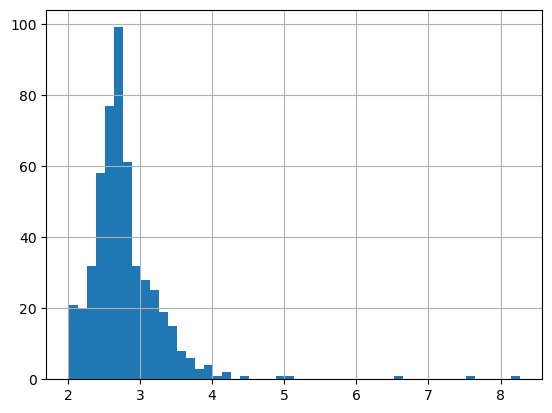

In [19]:
saccades_count_tw.amp_tot.hist(bins=50)

formula_emo_tw_vc = "amp_tot ~ C(emotion, Treatment('neutral')) * C(viewcond, Treatment('mono')) * C(tw, Treatment('p1'))"
model_emo_tw_vc = glm(formula_emo_tw_vc, data=saccades_count_tw, family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
print(model_emo_tw_vc.summary())
print(model_emo_tw_vc.wald_test_terms())
print("\n")
check_dispersion(model_emo_tw_vc)

mod = model_emo_tw_vc.wald_test_terms(scalar=True)
mdf = mod.summary_frame().reset_index(drop=True)
mdf["Factor"] = ["Intercept", "Emotion", "Viewcond", "Time window", "Emotion:Viewcond", "Emotion:Time window", "Viewcond:Time window", "Emotion:Viewcond:Time window"]
mdf.set_index("Factor", inplace=True)
mdf

## 5.3. MANOVA: Saccade direction ~ Emotion * Viewing Condition * Time Window

In [22]:
formula_emo = "angle_sin + angle_cos ~ C(emotion, Treatment('neutral'))" #  * C(tw, Treatment('p1'))"

formula_emo_vc_tw = "angle_sin + angle_cos ~ C(emotion, Treatment('neutral')) * C(viewcond) * C(tw, Treatment('p1'))"
model_emo_vc_tw = MANOVA.from_formula(formula_emo_vc_tw, data=saccades_count_tw, family=sm.families.Gaussian())
print(model_emo_vc_tw.mv_test())


                                         Multivariate linear model
                                                                                                           
--------------------------------------------------------------------------------------------------------------------
                 Intercept                 Value           Num DF           Den DF           F Value          Pr > F
--------------------------------------------------------------------------------------------------------------------
                    Wilks' lambda          0.9953          2.0000          484.0000           1.1382          0.3213
                   Pillai's trace          0.0047          2.0000          484.0000           1.1382          0.3213
           Hotelling-Lawley trace          0.0047          2.0000          484.0000           1.1382          0.3213
              Roy's greatest root          0.0047          2.0000          484.0000           1.1382          0.3213
------

### Post-hoc tests

In [ ]:
# cosine component:
erp_windows = timings.ERP_WINDOWS
time_wins = list(erp_windows.keys())
time_wins = [tw.lower() for tw in time_wins]

# As the data is "unbalanced" (not for all combinations there were actually saccades), we fill it up with NAs:

prodfactors = ["sub_id", "emotion", "viewcond", "tw"]
uniques = [saccades_count_tw.loc[:,s].unique() for s in prodfactors]
fulldesign = pd.DataFrame(product(*uniques), columns=prodfactors)

saccades_count_tw_full = (fulldesign
                            .merge(saccades_count_tw, on=["sub_id", "emotion", "viewcond", "tw"], how="left")
)

run_rmanova_and_posthoc(df_aov=saccades_count_tw_full,
                        depvar="angle_cos",
                        within=["emotion", "tw", "viewcond"],
                        posthoc_dim="tw",
                        posthoc_levels=time_wins,
                        subject="sub_id")

                      Anova
                    F Value Num DF  Den DF  Pr > F
--------------------------------------------------
emotion                 nan 3.0000  48.0000    nan
tw                      nan 3.0000  48.0000    nan
viewcond                nan 1.0000  16.0000    nan
emotion:tw              nan 9.0000 144.0000    nan
emotion:viewcond        nan 3.0000  48.0000    nan
tw:viewcond             nan 3.0000  48.0000    nan
emotion:tw:viewcond     nan 9.0000 144.0000    nan

p1 vs n170: t = 5.15, p = 0.000
p1 vs epn: t = 11.55, p = 0.000
p1 vs lpc: t = -0.65, p = 1.000
n170 vs epn: t = 5.93, p = 0.000
n170 vs lpc: t = -4.69, p = 0.000
epn vs lpc: t = -11.95, p = 0.000


In [27]:
# sine component:
erp_windows = timings.ERP_WINDOWS
time_wins = list(erp_windows.keys())
time_wins = [tw.lower() for tw in time_wins]

# As the data is "unbalanced" (not for all combinations there were actually saccades), we fill it up with NAs:

prodfactors = ["sub_id", "emotion", "viewcond", "tw"]
uniques = [saccades_count_tw.loc[:,s].unique() for s in prodfactors]
fulldesign = pd.DataFrame(product(*uniques), columns=prodfactors)

saccades_count_tw_full = (fulldesign
                            .merge(saccades_count_tw, on=["sub_id", "emotion", "viewcond", "tw"], how="left")
)

run_rmanova_and_posthoc(df_aov=saccades_count_tw_full,
                        depvar="angle_sin",
                        within=["emotion", "tw", "viewcond"],
                        posthoc_dim="tw",
                        posthoc_levels=time_wins,
                        subject="sub_id")

                      Anova
                    F Value Num DF  Den DF  Pr > F
--------------------------------------------------
emotion                 nan 3.0000  48.0000    nan
tw                      nan 3.0000  48.0000    nan
viewcond                nan 1.0000  16.0000    nan
emotion:tw              nan 9.0000 144.0000    nan
emotion:viewcond        nan 3.0000  48.0000    nan
tw:viewcond             nan 3.0000  48.0000    nan
emotion:tw:viewcond     nan 9.0000 144.0000    nan

p1 vs n170: t = -0.63, p = 1.000
p1 vs epn: t = 0.46, p = 1.000
p1 vs lpc: t = -1.65, p = 0.606
n170 vs epn: t = -0.04, p = 1.000
n170 vs lpc: t = -2.36, p = 0.117
epn vs lpc: t = -3.40, p = 0.005
